In [1]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals, print_function, division
import string
import random
from data_utils import *
from rnn import *
import torch
import codecs
from tqdm import tqdm
import string
import sacrebleu

In [2]:
#Set GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Load vocabulary files
input_lang = torch.load('data-bin/fra.data')
output_lang = torch.load('data-bin/eng.data')

#Create and empty RNN model
encoder = EncoderRNN(input_size=input_lang.n_words, device=device)
attn_decoder = AttnDecoderRNN(output_size=output_lang.n_words, device=device)


In [3]:
#Load the saved model weights into the RNN model
encoder.load_state_dict(torch.load('model/encoder'))
attn_decoder.load_state_dict(torch.load('model/decoder'))

<All keys matched successfully>

In [4]:
#Return the decoder output given input sentence 
#Additionally, the previous predicted word and previous decoder state can also be given as input
def translate_single_word(encoder, decoder, sentence, decoder_input=None, decoder_hidden=None, max_length=MAX_LENGTH, device=device):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence, device)
        input_length = input_tensor.size()[0]
        
        encoder = encoder.to(device)
        decoder = decoder.to(device)
        
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        if decoder_input==None:
            decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        else:
#             print(decoder_input)
            decoder_input = torch.tensor([[output_lang.word2index[decoder_input]]], device=device) 
        
        if decoder_hidden == None:        
            decoder_hidden = encoder_hidden
        
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        return decoder_output.data, decoder_hidden

In [5]:
previous_decoded_output = []

def beam_search(encoder,decoder,input_sentence,beam_size,max_length=MAX_LENGTH):
    decoded_output = ['']*beam_size
#     first_word = []
    val = 0
    #Predicted the first word
    decoder_output, decoder_hidden = translate_single_word(encoder, decoder, input_sentence, decoder_input=None, decoder_hidden=None)
    
    
    hidden_all = [decoder_hidden]*beam_size
    
    #Get the probability of all output words
    decoder_output_probs = decoder_output.data
    
    #Select the id of the word with maximum probability
    value, idx = torch.topk(decoder_output_probs, beam_size)
    for k in range(0, beam_size):
        #Convert the predicted id to the word
        
        first_word = (output_lang.index2word[idx[0][k].item()])

        #Add the predicted word to the output list and also set it as the previous prediction
        decoded_output[k] = first_word
        previous_decoded_output.append(first_word)
    
    probs_temp=[]
    #Loop until the maximum length
    for i in range(max_length):
        
        for k in range(0, beam_size):
            #Predict the next word given the previous prediction and the previous decoder hidden state
            decoder_output, decoder_hidden = translate_single_word(encoder, decoder, input_sentence, previous_decoded_output[k], hidden_all[k])
            
            #Get the probability of all output words
            decoder_output_probs = torch.cat([decoder_output_probs, decoder_output.data]) if k > 0 else decoder_output.data
            
            hidden_all[k] = decoder_hidden
            #Select the id of the word with maximum probability
        
        value, idx = torch.topk(decoder_output_probs, beam_size)
        if val == 0:
            val = value[0][k].item()
        else:
            val = val*value[0][k].item()
        probs_temp.append(val)
        #Break if end of sentence is predicted
        if idx[0][k].item() == EOS_token:
            continue
        
        #Else add the predicted word to the list
        else:
            #Convert the predicted id to the word
            
            max_prob1 = probs_temp.index(max(probs_temp)) 
            if max_prob1 == 0:
                beam_size = 1
            for x in range(0, beam_size):
                max_prob = probs_temp.index(max(probs_temp)) 
                selected_word = output_lang.index2word[idx[0][x].item()]
                decoded_output[max_prob] += " " + selected_word 
#                 print(decoded_output[max_prob])
                previous_decoded_output[max_prob] = selected_word 
    #Convert list of predicted words to a sentence and detokenize 
    output_translation = "".join(i for i in decoded_output)
    
    return output_translation.replace('EOS', '')


In [6]:

with open('data/test.fra', 'r', encoding='utf8') as f:
    source_sentences = [x.strip() for x in f]

target = codecs.open('test_beam_1.out','w',encoding='utf-8')

beam_size = 1
for i,source_sentence in enumerate(source_sentences):

#     target_sentence = normalizeString(target_sentences[i])
    input_sentence = normalizeString(source_sentence)
    
    hypothesis = beam_search(encoder, attn_decoder, input_sentence, beam_size=beam_size)

    print(hypothesis)
    target.write(hypothesis+'\n')
target.close()    

i am coming love .
you they re what that will have . . .
he is aware . of my . .
i m an expert on the . . .
i am going to buy a new car .
i am very sensitive to heat .
i am fond of my parents .
i m going abroad .
i am interested in politics .
i m looking a . .
i m trying to the the . .
i re satisfied that i m satisfied .
she m learning the same ?
he re going to go your afternoon .
he is in . . .
i re not staying .
she s standing old !
we is in in a for . .
i i am grateful to your your . .
he s a . .
i re a one who ? ?
he re ? ?
he is used his his . .
he s ready ready .
i m looking for have . .
he m what she s ?
he is taking an fast at his room .
i re very very . .
he is my friend of my job .
i m calling him him him .
i m studying .
you re looking to to you you .
he s not on his . .
i s a a a . .
he re working about my life .
i am from tokyo . .
i m just it he s a . .
i re going to do you ?
he s the last he out of . .
he s looking for to . .
he is his his his s .
he s in in in a house .

In [7]:
!sacrebleu data/test.eng < test_beam_1.out

{
 "name": "BLEU",
 "score": 12.5,
 "signature": "nrefs:1|case:mixed|eff:no|tok:13a|smooth:exp|version:2.0.0",
 "verbose_score": "40.7/13.1/7.9/5.7 (BP = 1.000 ratio = 1.046 hyp_len = 6506 ref_len = 6218)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "13a",
 "smooth": "exp",
 "version": "2.0.0"
}


sacreBLEU: That's 100 lines that end in a tokenized period ('.')
sacreBLEU: It looks like you forgot to detokenize your test data, which may hurt your score.
sacreBLEU: If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


In [12]:
import matplotlib.pyplot as plt
x = [0, 1, 2, 3, 4, 5,6, 7, 8, 9 ,10, 11, 12, 13, 14,15,16,17,18,19]
scores = [12.7, 12.5, 10.5, 9.5, 10.4, 10.5, 9.5, 9.5, 8.5, 10.4, 10.5, 9.5, 8.5, 9.4, 10.5, 8.5, 9.5, 8.5, 10.4, 10.5]

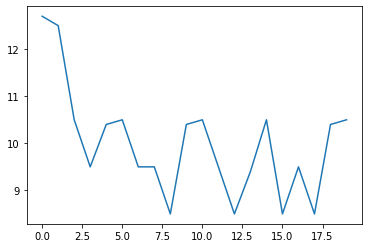

In [13]:
plt.plot( scores, x)
